In [1]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

/Users/aakritinag/Documents/GitHub/Agentic-RAG/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/Users/aakritinag/Documents/GitHub/Agentic-RAG/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import init_chat_model

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [4]:
llm=init_chat_model("openai:gpt-4o-mini")
llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x1095a46e0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x1095a5160>, root_client=<openai.OpenAI object at 0x108fe9a90>, root_async_client=<openai.AsyncOpenAI object at 0x1095a4ec0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [5]:
# generic function to create a retrieval tool
from langchain_core.tools import Tool

def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)


internal_tool_1 = make_retriever_tool_from_text("research_notes.txt",
                                              "InternalResearchNotes",
                                              "Search internal research notes for experimental results")

internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x10852a700>)

In [6]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_tool = TavilySearch(max_results=5)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
from typing import List
from langchain_core.tools import tool
import requests
from bs4 import BeautifulSoup

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Scrape provided web pages for detailed information (with timeouts)."""
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/120.0.0.0 Safari/537.36"
    }

    out = []
    for url in urls:
        try:
            r = requests.get(url, headers=headers, timeout=(5, 15))  # connect, read timeout
            r.raise_for_status()

            soup = BeautifulSoup(r.text, "html.parser")

            title = soup.title.get_text(strip=True) if soup.title else ""
            text = soup.get_text("\n", strip=True)

            out.append(f'<Document name="{title}">\n{text[:12000]}\n</Document>')  # cap size

        except Exception as e:
            out.append(f'<Document name="">\nERROR scraping {url}: {repr(e)}\n</Document>')

    return "\n\n".join(out)


In [8]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [9]:
WORKING_DIRECTORY

PosixPath('/var/folders/m4/yx3n91cs37nf91mrrvjx9s2r0000gn/T/tmp3odp93zi')

In [10]:
# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [11]:
def add_called(existing: list[str] | None, new: list[str] | None) -> list[str]:
    existing = existing or []
    new = new or []
    out = []
    for x in existing + new:
        if x not in out:
            out.append(x)
    return out

In [12]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages
from langchain_core.messages import AIMessage

    
class State(MessagesState, TypedDict):
    next: str
    called: Annotated[list[str], add_called]


In [13]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import END
from langgraph.types import Command

def make_supervisor_node(llm: BaseChatModel, members: list[str]):

    options = ["FINISH"] + members

    #  f-string so members is real text, not "{members}"
    system_prompt = (
        f"You are a supervisor managing workers: {members}.\n"
        "Pick ONE worker to act next.\n"
        "Rules:\n"
        "- Prefer calling each worker at most once.\n"
        "- If a worker already replied, do NOT call them again unless absolutely necessary.\n"
        "- If you have enough information to satisfy the user, respond with FINISH.\n"
        "Return ONLY one of: " + " | ".join(options)
    )

    class Router(TypedDict):
        next: Literal[*options]
    
    
    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        called = set(state.get("called", []))

        # finish if all members called
        if set(members).issubset(called) and members:
            return Command(goto="__end__", update={"next": "__end__", "called": list(called)})

        remaining = [m for m in members if m not in called]

        # Only allow FINISH after at least one worker has been called
        allow_finish = len(called) > 0
        allowed = (["FINISH"] if allow_finish else []) + remaining

        class RouterRemaining(TypedDict):
            next: Literal[*allowed]

        messages = [{"role": "system", "content": system_prompt}] + state["messages"]
        response = llm.with_structured_output(RouterRemaining).invoke(messages)

        goto = response["next"]
        if goto == "FINISH":
            goto = "__end__"

        return Command(goto=goto, update={"next": goto, "called": list(state.get("called", []))})


    return supervisor_node


In [14]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent


search_agent = create_agent(llm, tools=[tavily_tool,internal_tool_1])
search_agent
    
def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="search")
            ],
            "called": ["search"],
        },
        goto="supervisor",
    )


### sub agent
web_scraper_agent = create_agent(llm, tools=[scrape_webpages])

    
def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="web_scraper")
            ],
            "called": ["web_scraper"],
        },
        goto="supervisor",
    )


In [15]:
research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])
research_supervisor_node

<function __main__.make_supervisor_node.<locals>.supervisor_node(state: __main__.State) -> langgraph.types.Command[typing.Literal['search', 'web_scraper', '__end__']]>

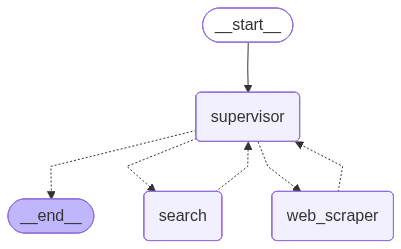

In [16]:
# research_builder = StateGraph(State)
# research_builder.add_node("supervisor", research_supervisor_node)
# research_builder.add_node("search", search_node)
# research_builder.add_node("web_scraper", web_scraper_node)

# research_builder.add_edge(START, "supervisor")
# research_graph = research_builder.compile()
# research_graph

In [17]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")

# Conditional routing based on state["next"]
research_builder.add_conditional_edges(
    "supervisor",
    lambda s: s["next"],
    {
        "search": "search",
        "web_scraper": "web_scraper",
        "__end__": END,
    },
)

# workers always report back
research_builder.add_edge("search", "supervisor")
research_builder.add_edge("web_scraper", "supervisor")

research_graph = research_builder.compile()



In [18]:
out = research_graph.invoke(
    {"messages": [("user", "Give me 3 key points on Longformer vs Reformer")],
     "called": [],
     "next": "search"},
    config={"recursion_limit": 10}
)

In [28]:
from langchain_core.messages import AIMessage

last_ai = next(m for m in reversed(out["messages"]) if isinstance(m, AIMessage))
print("called:", out.get("called"))
print(last_ai.content)


called: ['search']
Here are three key points comparing Longformer and Reformer, two transformer architectures designed to handle long sequences efficiently:

1. **Attention Mechanism**:
   - **Longformer** utilizes a combination of sparse and global attention mechanisms. It incorporates local context through a sliding window approach and employs global attention for specific tokens to manage long-range dependencies effectively.
   - **Reformer**, on the other hand, leverages Locality-Sensitive Hashing (LSH) to dynamically find relevant tokens anywhere within the sequence. This reduces the attention complexity to near-linear levels, making it highly efficient for very long sequences.

2. **Computational Efficiency**:
   - The **Reformer** is designed to have a significantly lower computational cost compared to traditional transformers. It reduces memory usage while maintaining performance, making it suitable for processing sequences with millions of tokens.
   - **Longformer** also aims

In [20]:
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

In [21]:
from langchain_core.messages import SystemMessage

doc_writer_agent = create_agent(
    llm.bind(messages=[SystemMessage(content=
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    )]),
    tools=[write_document, edit_document, read_document],
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": state["messages"] + [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ],
            "called": ["doc_writer"],
        },
        goto="supervisor",
    )



note_taking_agent = create_agent(
    llm.bind(messages=[SystemMessage(content=
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    )]),
    tools=[create_outline, read_document],
)



def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": state["messages"] + [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ],
            "called": ["note_taker"],
        },
        goto="supervisor",
    )



doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker"])

In [22]:
doc_builder = StateGraph(State)
doc_builder.add_node("supervisor", doc_writing_supervisor_node)
doc_builder.add_node("doc_writer", doc_writing_node)
doc_builder.add_node("note_taker", note_taking_node)


doc_builder.add_edge(START, "supervisor")

doc_builder.add_conditional_edges(
    "supervisor",
    lambda s: s["next"],
    {
        "doc_writer": "doc_writer",
        "note_taker": "note_taker",
        "__end__": END,
    },
)

doc_builder.add_edge("doc_writer", "supervisor")
doc_builder.add_edge("note_taker", "supervisor")

doc_graph = doc_builder.compile()



In [23]:
from langchain_core.messages import BaseMessage
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])
teams_supervisor_node

<function __main__.make_supervisor_node.<locals>.supervisor_node(state: __main__.State) -> langgraph.types.Command[typing.Literal['research_team', 'writing_team', '__end__']]>

In [24]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke(
        {"messages": state["messages"], "called": []},   
        config={"recursion_limit": 6}                   
    )
    return Command(
        update={
            "messages": state["messages"] + [
                HumanMessage(content=response["messages"][-1].content, name="research_team")
            ]
        },
        goto="supervisor",
    )


    
def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = doc_graph.invoke(
        {"messages": state["messages"], "called": []},   # keep called local to subgraph
        config={"recursion_limit": 10}
    )
    return Command(
        update={
            "messages": state["messages"] + [
                HumanMessage(content=response["messages"][-1].content, name="writing_team")
            ]
        },
        goto="supervisor",
    )

super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")

super_builder.add_conditional_edges(
    "supervisor",
    lambda s: s["next"],
    {
        "research_team": "research_team",
        "writing_team": "writing_team",
        "__end__": END,
    },
)

super_builder.add_edge("research_team", "supervisor")
super_builder.add_edge("writing_team", "supervisor")

super_graph = super_builder.compile()


In [25]:
response = super_graph.invoke(
    {"messages": [("user", "Write about transformer variants in production deployments.")], "called": []},
    config={"recursion_limit": 15}
)


In [27]:
messages = response["messages"]
final_text = messages[-1].content

print(final_text)


**Transformer Variants in Production Deployments**

Transformer models have revolutionized the fields of natural language processing (NLP) and deep learning since their introduction. With the rise of applications such as chatbots, search engines, and content generation systems, deploying these models in production has become a critical focus for organizations. Here's a breakdown of important transformer variants and considerations for their deployment in production environments.

### Key Transformer Variants

1. **BERT (Bidirectional Encoder Representations from Transformers)**:
   - Developed by Google, BERT is designed to better understand the context of words in search queries. It processes words in relation to all the other words in a sentence rather than one by one, greatly improving search relevance, especially for complex queries.

2. **GPT (Generative Pre-trained Transformer)**:
   - Created by OpenAI, GPT excels in text generation tasks. It uses a unidirectional approach but h